# Applying Custom CNN + SEBlock Attention Module On Brain Cancer Dataset

In [20]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [21]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [22]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [23]:
data_dir = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: brain_menin --> count: 5000
class: brain_glioma --> count: 5000
class: brain_tumor --> count: 5000


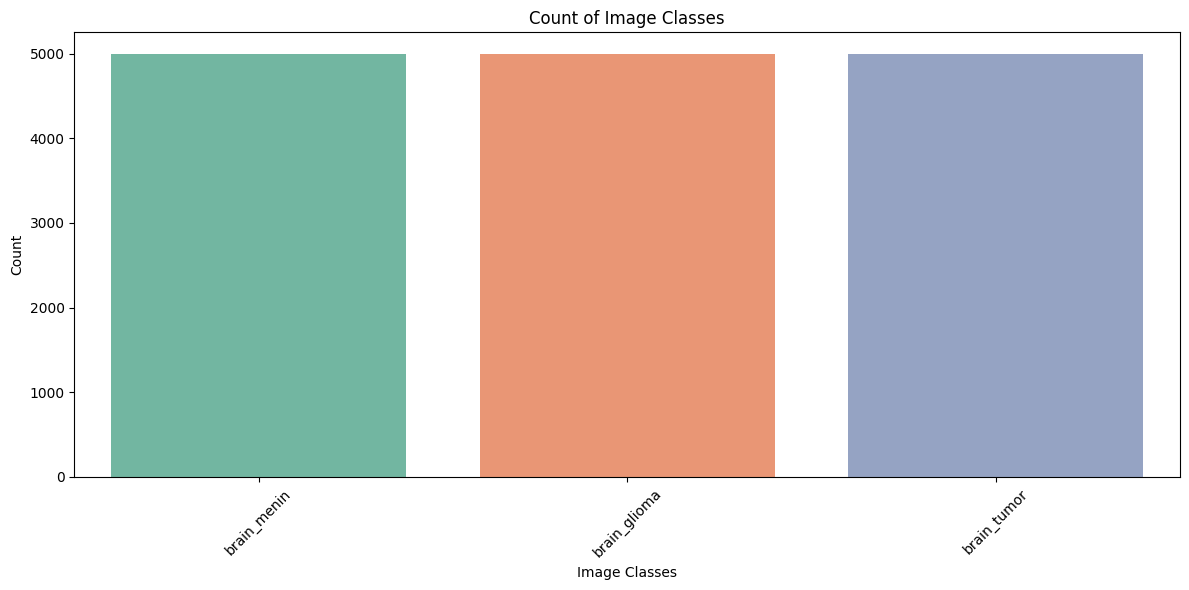

In [24]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

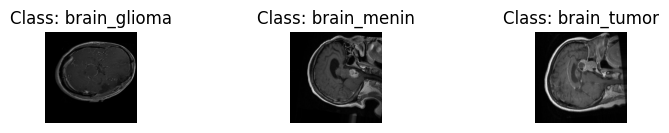

In [25]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [26]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [27]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  10500
Validation Data:  2250
Test Data:  2250
-------------------------------------------
Total amounts of data in the dataset:  15000


In [28]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class           Count
------------  -------
brain_tumor      3500
brain_menin      3500
brain_glioma     3500

Validation Dataset
Class           Count
------------  -------
brain_glioma      750
brain_menin       750
brain_tumor       750

Test Dataset
Class           Count
------------  -------
brain_tumor       750
brain_menin       750
brain_glioma      750


label mapping

In [29]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


### Device Variable

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [31]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [32]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [33]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert('RGB')

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [34]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [35]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)       # [B, C]
        y = self.fc(y).view(b, c, 1, 1)              # [B, C, 1, 1]
        return x * y.expand_as(x)

### Convolutional Neural Netwirk (G7CNN)

In [36]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112
            
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56
            

            # Block 3
            nn.Conv2d(64, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 84 x 28 x 28
            SEBlock(84),

            # Block 4
            nn.Conv2d(84, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 14 x 14
            SEBlock(128),
            
            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 7 x 7
            SEBlock(256),

        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 256 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 256
            nn.Linear(256, 256),                 # → 256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [39]:
total_class = 3
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)
model.classifier[-1] = nn.Linear(256, total_class)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Training

In [40]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 165/165 [00:54<00:00,  3.02it/s, acc=0.808, loss=0.526]

Training Loss: 0.526 Acc: 0.808


Validation Loss: 1.364 Acc: 0.578
✅ Best model saved at epoch 1 with validation accuracy: 0.578


Epoch 2/150: 100%|██████████| 165/165 [00:37<00:00,  4.39it/s, acc=0.909, loss=0.252]

Training Loss: 0.252 Acc: 0.909


Validation Loss: 0.395 Acc: 0.843
✅ Best model saved at epoch 2 with validation accuracy: 0.843


Epoch 3/150: 100%|██████████| 165/165 [00:38<00:00,  4.32it/s, acc=0.925, loss=0.206]

Training Loss: 0.206 Acc: 0.925


Validation Loss: 0.145 Acc: 0.950
✅ Best model saved at epoch 3 with validation accuracy: 0.950


Epoch 4/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.934, loss=0.179]

Training Loss: 0.179 Acc: 0.934


Validation Loss: 0.105 Acc: 0.966
✅ Best model saved at epoch 4 with validation accuracy: 0.966


Epoch 5/150: 100%|██████████| 165/165 [00:38<00:00,  4.32it/s, acc=0.95, loss=0.137] 

Training Loss: 0.137 Acc: 0.950


Validation Loss: 0.623 Acc: 0.804


Epoch 6/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.945, loss=0.156]

Training Loss: 0.156 Acc: 0.945


Validation Loss: 0.754 Acc: 0.759


Epoch 7/150: 100%|██████████| 165/165 [00:36<00:00,  4.49it/s, acc=0.959, loss=0.113]

Training Loss: 0.113 Acc: 0.959


Validation Loss: 0.145 Acc: 0.947


Epoch 8/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.965, loss=0.0997]

Training Loss: 0.100 Acc: 0.965


Validation Loss: 0.130 Acc: 0.947


Epoch 9/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.974, loss=0.0775]

Training Loss: 0.077 Acc: 0.974


Validation Loss: 0.511 Acc: 0.832


Epoch 10/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.962, loss=0.105]

Training Loss: 0.105 Acc: 0.962


Validation Loss: 0.050 Acc: 0.982
✅ Best model saved at epoch 10 with validation accuracy: 0.982


Epoch 11/150: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s, acc=0.977, loss=0.0632]

Training Loss: 0.063 Acc: 0.977


Validation Loss: 0.160 Acc: 0.943


Epoch 12/150: 100%|██████████| 165/165 [00:37<00:00,  4.46it/s, acc=0.978, loss=0.0611]

Training Loss: 0.061 Acc: 0.978


Validation Loss: 0.690 Acc: 0.796


Epoch 13/150: 100%|██████████| 165/165 [00:36<00:00,  4.48it/s, acc=0.97, loss=0.0881] 

Training Loss: 0.088 Acc: 0.970


Validation Loss: 0.044 Acc: 0.986
✅ Best model saved at epoch 13 with validation accuracy: 0.986


Epoch 14/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.982, loss=0.0483]

Training Loss: 0.048 Acc: 0.982


Validation Loss: 0.048 Acc: 0.983


Epoch 15/150: 100%|██████████| 165/165 [00:37<00:00,  4.38it/s, acc=0.988, loss=0.0336]

Training Loss: 0.034 Acc: 0.988


Validation Loss: 0.191 Acc: 0.937


Epoch 16/150: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s, acc=0.985, loss=0.0433]

Training Loss: 0.043 Acc: 0.985


Validation Loss: 0.436 Acc: 0.870


Epoch 17/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.985, loss=0.0414]

Training Loss: 0.041 Acc: 0.985


Validation Loss: 0.052 Acc: 0.983


Epoch 18/150: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s, acc=0.982, loss=0.0514]

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.616 Acc: 0.834


Epoch 19/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.987, loss=0.0396]

Training Loss: 0.040 Acc: 0.987


Validation Loss: 0.044 Acc: 0.984


Epoch 20/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.983, loss=0.0531]

Training Loss: 0.053 Acc: 0.983


Validation Loss: 0.033 Acc: 0.986


Epoch 21/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.989, loss=0.0333]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.038 Acc: 0.986


Epoch 22/150: 100%|██████████| 165/165 [00:37<00:00,  4.46it/s, acc=0.982, loss=0.0513]

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.062 Acc: 0.974


Epoch 23/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.993, loss=0.0233]

Training Loss: 0.023 Acc: 0.993


Validation Loss: 0.013 Acc: 0.996
✅ Best model saved at epoch 23 with validation accuracy: 0.996


Epoch 24/150: 100%|██████████| 165/165 [00:37<00:00,  4.35it/s, acc=0.992, loss=0.0252]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.017 Acc: 0.994


Epoch 25/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.992, loss=0.0245]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.020 Acc: 0.993


Epoch 26/150: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s, acc=0.98, loss=0.0545] 

Training Loss: 0.054 Acc: 0.980


Validation Loss: 0.027 Acc: 0.991


Epoch 27/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.991, loss=0.0261]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.015 Acc: 0.992


Epoch 28/150: 100%|██████████| 165/165 [00:38<00:00,  4.33it/s, acc=0.994, loss=0.0194]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.145 Acc: 0.951


Epoch 29/150: 100%|██████████| 165/165 [00:38<00:00,  4.33it/s, acc=0.979, loss=0.0592]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.016 Acc: 0.995


Epoch 30/150: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s, acc=0.994, loss=0.019] 

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.017 Acc: 0.993


Epoch 31/150: 100%|██████████| 165/165 [00:37<00:00,  4.34it/s, acc=0.992, loss=0.0221]

Training Loss: 0.022 Acc: 0.992


Validation Loss: 0.075 Acc: 0.974


Epoch 32/150: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s, acc=0.993, loss=0.0196]

Training Loss: 0.020 Acc: 0.993


Validation Loss: 0.058 Acc: 0.978


Epoch 33/150: 100%|██████████| 165/165 [00:38<00:00,  4.33it/s, acc=0.995, loss=0.0171]

Training Loss: 0.017 Acc: 0.995


Validation Loss: 0.009 Acc: 0.997
✅ Best model saved at epoch 33 with validation accuracy: 0.997


Epoch 34/150: 100%|██████████| 165/165 [00:37<00:00,  4.35it/s, acc=0.995, loss=0.0153]

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.012 Acc: 0.996


Epoch 35/150: 100%|██████████| 165/165 [00:38<00:00,  4.31it/s, acc=0.993, loss=0.0209]

Training Loss: 0.021 Acc: 0.993


Validation Loss: 0.097 Acc: 0.964


Epoch 36/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.983, loss=0.0472]

Training Loss: 0.047 Acc: 0.983


Validation Loss: 0.033 Acc: 0.988


Epoch 37/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.995, loss=0.0161]

Training Loss: 0.016 Acc: 0.995


Validation Loss: 0.174 Acc: 0.940


Epoch 38/150: 100%|██████████| 165/165 [00:37<00:00,  4.35it/s, acc=0.996, loss=0.0122]

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.019 Acc: 0.991


Epoch 39/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.996, loss=0.0146]

Training Loss: 0.015 Acc: 0.996


Validation Loss: 0.017 Acc: 0.994


Epoch 40/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.995, loss=0.0139]

Training Loss: 0.014 Acc: 0.995


Validation Loss: 0.308 Acc: 0.907


Epoch 41/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.979, loss=0.0647]

Training Loss: 0.065 Acc: 0.979


Validation Loss: 0.142 Acc: 0.948


Epoch 42/150: 100%|██████████| 165/165 [00:39<00:00,  4.22it/s, acc=0.99, loss=0.0322] 

Training Loss: 0.032 Acc: 0.990


Validation Loss: 0.037 Acc: 0.984


Epoch 43/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.996, loss=0.0134]

Training Loss: 0.013 Acc: 0.996


Validation Loss: 0.059 Acc: 0.978


Epoch 44/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.997, loss=0.0101] 

Training Loss: 0.010 Acc: 0.997


Validation Loss: 0.007 Acc: 0.998
✅ Best model saved at epoch 44 with validation accuracy: 0.998


Epoch 45/150: 100%|██████████| 165/165 [00:39<00:00,  4.20it/s, acc=0.997, loss=0.00804]

Training Loss: 0.008 Acc: 0.997


Validation Loss: 0.004 Acc: 0.999
✅ Best model saved at epoch 45 with validation accuracy: 0.999


Epoch 46/150: 100%|██████████| 165/165 [00:40<00:00,  4.12it/s, acc=0.996, loss=0.0122]

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.030 Acc: 0.991


Epoch 47/150: 100%|██████████| 165/165 [00:38<00:00,  4.27it/s, acc=0.996, loss=0.0107]

Training Loss: 0.011 Acc: 0.996


Validation Loss: 0.230 Acc: 0.925


Epoch 48/150: 100%|██████████| 165/165 [00:38<00:00,  4.32it/s, acc=0.983, loss=0.052] 

Training Loss: 0.052 Acc: 0.983


Validation Loss: 0.932 Acc: 0.805


Epoch 49/150: 100%|██████████| 165/165 [00:38<00:00,  4.25it/s, acc=0.979, loss=0.0632]

Training Loss: 0.063 Acc: 0.979


Validation Loss: 0.024 Acc: 0.990


Epoch 50/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.992, loss=0.0226]

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.042 Acc: 0.984


Epoch 51/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.996, loss=0.0127]

Training Loss: 0.013 Acc: 0.996


Validation Loss: 0.006 Acc: 0.999
✅ Best model saved at epoch 51 with validation accuracy: 0.999


Epoch 52/150: 100%|██████████| 165/165 [00:39<00:00,  4.20it/s, acc=0.998, loss=0.0101]

Training Loss: 0.010 Acc: 0.998


Validation Loss: 0.018 Acc: 0.995


Epoch 53/150: 100%|██████████| 165/165 [00:39<00:00,  4.13it/s, acc=0.995, loss=0.0124]

Training Loss: 0.012 Acc: 0.995


Validation Loss: 0.007 Acc: 0.997


Epoch 54/150: 100%|██████████| 165/165 [00:39<00:00,  4.20it/s, acc=0.998, loss=0.00785]

Training Loss: 0.008 Acc: 0.998


Validation Loss: 0.080 Acc: 0.978


Epoch 55/150: 100%|██████████| 165/165 [00:39<00:00,  4.17it/s, acc=0.995, loss=0.0136]

Training Loss: 0.014 Acc: 0.995


Validation Loss: 0.013 Acc: 0.995


Epoch 56/150: 100%|██████████| 165/165 [00:39<00:00,  4.18it/s, acc=0.997, loss=0.00842]

Training Loss: 0.008 Acc: 0.997


Validation Loss: 0.082 Acc: 0.976


Epoch 57/150: 100%|██████████| 165/165 [00:39<00:00,  4.19it/s, acc=0.984, loss=0.0489]

Training Loss: 0.049 Acc: 0.984


Validation Loss: 0.041 Acc: 0.984


Epoch 58/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.987, loss=0.039] 

Training Loss: 0.039 Acc: 0.987


Validation Loss: 0.011 Acc: 0.997


Epoch 59/150: 100%|██████████| 165/165 [00:39<00:00,  4.17it/s, acc=0.996, loss=0.0121]

Training Loss: 0.012 Acc: 0.996


Validation Loss: 0.002 Acc: 1.000
✅ Best model saved at epoch 59 with validation accuracy: 1.000


Epoch 60/150: 100%|██████████| 165/165 [00:39<00:00,  4.19it/s, acc=0.998, loss=0.00548]

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.005 Acc: 0.998


Epoch 61/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.998, loss=0.00536]

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.075 Acc: 0.977


Epoch 62/150: 100%|██████████| 165/165 [00:38<00:00,  4.28it/s, acc=0.989, loss=0.0326]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.009 Acc: 0.997


Epoch 63/150: 100%|██████████| 165/165 [00:38<00:00,  4.26it/s, acc=0.997, loss=0.0107]

Training Loss: 0.011 Acc: 0.997


Validation Loss: 0.020 Acc: 0.993


Epoch 64/150: 100%|██████████| 165/165 [00:38<00:00,  4.31it/s, acc=0.997, loss=0.0082] 

Training Loss: 0.008 Acc: 0.997


Validation Loss: 0.018 Acc: 0.996


Epoch 65/150: 100%|██████████| 165/165 [00:38<00:00,  4.25it/s, acc=0.998, loss=0.00661]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.009 Acc: 0.996


Epoch 66/150: 100%|██████████| 165/165 [00:38<00:00,  4.26it/s, acc=0.999, loss=0.00421]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.003 Acc: 1.000


Epoch 67/150: 100%|██████████| 165/165 [00:38<00:00,  4.23it/s, acc=0.998, loss=0.00683]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.018 Acc: 0.995


Epoch 68/150: 100%|██████████| 165/165 [00:39<00:00,  4.15it/s, acc=0.995, loss=0.0133]

Training Loss: 0.013 Acc: 0.995


Validation Loss: 0.077 Acc: 0.974


Epoch 69/150: 100%|██████████| 165/165 [00:39<00:00,  4.14it/s, acc=0.99, loss=0.0296] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.025 Acc: 0.992


Epoch 70/150: 100%|██████████| 165/165 [00:38<00:00,  4.23it/s, acc=0.998, loss=0.00657]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.028 Acc: 0.988


Epoch 71/150: 100%|██████████| 165/165 [00:39<00:00,  4.22it/s, acc=0.999, loss=0.0049] 

Training Loss: 0.005 Acc: 0.999


Validation Loss: 0.013 Acc: 0.995


Epoch 72/150: 100%|██████████| 165/165 [00:39<00:00,  4.18it/s, acc=0.997, loss=0.00719]

Training Loss: 0.007 Acc: 0.997


Validation Loss: 0.016 Acc: 0.995


Epoch 73/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.998, loss=0.00778]

Training Loss: 0.008 Acc: 0.998


Validation Loss: 0.168 Acc: 0.961


Epoch 74/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.979, loss=0.0642]

Training Loss: 0.064 Acc: 0.979


Validation Loss: 0.027 Acc: 0.990


Epoch 75/150: 100%|██████████| 165/165 [00:38<00:00,  4.27it/s, acc=0.995, loss=0.0148]

Training Loss: 0.015 Acc: 0.995


Validation Loss: 0.016 Acc: 0.994


Epoch 76/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.989, loss=0.0337]

Training Loss: 0.034 Acc: 0.989


Validation Loss: 0.039 Acc: 0.986


Epoch 77/150: 100%|██████████| 165/165 [00:38<00:00,  4.27it/s, acc=0.991, loss=0.0275]

Training Loss: 0.027 Acc: 0.991


Validation Loss: 0.025 Acc: 0.990


Epoch 78/150: 100%|██████████| 165/165 [00:39<00:00,  4.18it/s, acc=0.993, loss=0.0218]

Training Loss: 0.022 Acc: 0.993


Validation Loss: 0.014 Acc: 0.994


Epoch 79/150: 100%|██████████| 165/165 [00:39<00:00,  4.23it/s, acc=0.996, loss=0.0128]

Training Loss: 0.013 Acc: 0.996


Validation Loss: 0.007 Acc: 0.998


Epoch 80/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.997, loss=0.00703]

Training Loss: 0.007 Acc: 0.997


Validation Loss: 0.068 Acc: 0.972


Epoch 81/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.994, loss=0.0162]

Training Loss: 0.016 Acc: 0.994


Validation Loss: 0.004 Acc: 0.998


Epoch 82/150: 100%|██████████| 165/165 [00:39<00:00,  4.20it/s, acc=0.993, loss=0.0179]

Training Loss: 0.018 Acc: 0.993


Validation Loss: 0.010 Acc: 0.998


Epoch 83/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.999, loss=0.00482]

Training Loss: 0.005 Acc: 0.999


Validation Loss: 0.001 Acc: 1.000
✅ Best model saved at epoch 83 with validation accuracy: 1.000


Epoch 84/150: 100%|██████████| 165/165 [00:39<00:00,  4.17it/s, acc=0.998, loss=0.00594]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.003 Acc: 0.999


Epoch 85/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.999, loss=0.00374]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.004 Acc: 0.999


Epoch 86/150: 100%|██████████| 165/165 [00:38<00:00,  4.25it/s, acc=0.998, loss=0.00428]

Training Loss: 0.004 Acc: 0.998


Validation Loss: 0.008 Acc: 0.997


Epoch 87/150: 100%|██████████| 165/165 [00:38<00:00,  4.28it/s, acc=0.998, loss=0.0042] 

Training Loss: 0.004 Acc: 0.998


Validation Loss: 0.002 Acc: 0.999


Epoch 88/150: 100%|██████████| 165/165 [00:38<00:00,  4.31it/s, acc=0.998, loss=0.00678]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.005 Acc: 0.997


Epoch 89/150: 100%|██████████| 165/165 [00:38<00:00,  4.28it/s, acc=0.999, loss=0.00322]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.008 Acc: 0.997


Epoch 90/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.991, loss=0.034] 

Training Loss: 0.034 Acc: 0.991


Validation Loss: 0.018 Acc: 0.992


Epoch 91/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.999, loss=0.00555]

Training Loss: 0.006 Acc: 0.999


Validation Loss: 0.013 Acc: 0.996


Epoch 92/150: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s, acc=0.998, loss=0.00793]

Training Loss: 0.008 Acc: 0.998


Validation Loss: 0.020 Acc: 0.992


Epoch 93/150: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s, acc=0.998, loss=0.00498]

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.007 Acc: 0.998


Epoch 94/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.999, loss=0.00572]

Training Loss: 0.006 Acc: 0.999


Validation Loss: 0.003 Acc: 0.999


Epoch 95/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.997, loss=0.00835]

Training Loss: 0.008 Acc: 0.997


Validation Loss: 0.008 Acc: 0.997


Epoch 96/150: 100%|██████████| 165/165 [00:38<00:00,  4.34it/s, acc=0.998, loss=0.00644]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.011 Acc: 0.995


Epoch 97/150: 100%|██████████| 165/165 [00:38<00:00,  4.34it/s, acc=0.994, loss=0.0164]

Training Loss: 0.016 Acc: 0.994


Validation Loss: 0.003 Acc: 0.999


Epoch 98/150: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s, acc=0.998, loss=0.00679]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.227 Acc: 0.943


Epoch 99/150: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s, acc=0.998, loss=0.00615]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.349 Acc: 0.922


Epoch 100/150: 100%|██████████| 165/165 [00:36<00:00,  4.47it/s, acc=0.99, loss=0.0286] 

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.002 Acc: 1.000


Epoch 101/150: 100%|██████████| 165/165 [00:37<00:00,  4.38it/s, acc=0.999, loss=0.00359]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.003 Acc: 0.999


Epoch 102/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.999, loss=0.00376]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.322 Acc: 0.903


Epoch 103/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.991, loss=0.0325]

Training Loss: 0.032 Acc: 0.991


Validation Loss: 0.007 Acc: 0.997


Epoch 104/150: 100%|██████████| 165/165 [00:37<00:00,  4.46it/s, acc=0.998, loss=0.00535]

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.009 Acc: 0.998


Epoch 105/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.998, loss=0.00637]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.004 Acc: 0.999


Epoch 106/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=1, loss=0.00284]

Training Loss: 0.003 Acc: 1.000


Validation Loss: 0.053 Acc: 0.981


Epoch 107/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.983, loss=0.0523]

Training Loss: 0.052 Acc: 0.983


Validation Loss: 0.032 Acc: 0.989


Epoch 108/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.999, loss=0.00577]

Training Loss: 0.006 Acc: 0.999


Validation Loss: 0.007 Acc: 0.997


Epoch 109/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.998, loss=0.0054] 

Training Loss: 0.005 Acc: 0.998


Validation Loss: 0.003 Acc: 0.999


Epoch 110/150: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s, acc=0.999, loss=0.00433]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.046 Acc: 0.988


Epoch 111/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.998, loss=0.00568]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.004 Acc: 0.999


Epoch 112/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.999, loss=0.00373]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.002 Acc: 0.999


Epoch 113/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.999, loss=0.00442]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.217 Acc: 0.933


Epoch 114/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.99, loss=0.0284] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.008 Acc: 0.996


Epoch 115/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.998, loss=0.00726]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.005 Acc: 0.999


Epoch 116/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.996, loss=0.0104]

Training Loss: 0.010 Acc: 0.996


Validation Loss: 0.005 Acc: 0.999


Epoch 117/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.991, loss=0.0265]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.066 Acc: 0.978


Epoch 118/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.986, loss=0.0413]

Training Loss: 0.041 Acc: 0.986


Validation Loss: 0.011 Acc: 0.996


Epoch 119/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.998, loss=0.00612]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.003 Acc: 0.999


Epoch 120/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=1, loss=0.00298]    

Training Loss: 0.003 Acc: 1.000


Validation Loss: 0.002 Acc: 1.000


Epoch 121/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.999, loss=0.00274]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.002 Acc: 0.999


Epoch 122/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.999, loss=0.00281]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.001 Acc: 1.000


Epoch 123/150: 100%|██████████| 165/165 [00:37<00:00,  4.39it/s, acc=0.999, loss=0.0017] 

Training Loss: 0.002 Acc: 0.999


Validation Loss: 0.002 Acc: 1.000


Epoch 124/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.999, loss=0.00311]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.001 Acc: 1.000


Epoch 125/150: 100%|██████████| 165/165 [00:36<00:00,  4.49it/s, acc=0.999, loss=0.00204]

Training Loss: 0.002 Acc: 0.999


Validation Loss: 0.002 Acc: 1.000


Epoch 126/150: 100%|██████████| 165/165 [00:36<00:00,  4.47it/s, acc=0.999, loss=0.00304]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.001 Acc: 1.000


Epoch 127/150: 100%|██████████| 165/165 [00:37<00:00,  4.46it/s, acc=0.998, loss=0.00429]

Training Loss: 0.004 Acc: 0.998


Validation Loss: 0.004 Acc: 0.999


Epoch 128/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.999, loss=0.00368]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.018 Acc: 0.993


Epoch 129/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.997, loss=0.00689]

Training Loss: 0.007 Acc: 0.997


Validation Loss: 0.007 Acc: 0.996


Epoch 130/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.998, loss=0.00787]

Training Loss: 0.008 Acc: 0.998


Validation Loss: 0.001 Acc: 1.000


Epoch 131/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.994, loss=0.016] 

Training Loss: 0.016 Acc: 0.994


Validation Loss: 0.056 Acc: 0.983


Epoch 132/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=0.992, loss=0.0223]

Training Loss: 0.022 Acc: 0.992


Validation Loss: 0.002 Acc: 1.000


Epoch 133/150: 100%|██████████| 165/165 [00:37<00:00,  4.44it/s, acc=0.999, loss=0.00338]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.003 Acc: 0.999


Epoch 134/150: 100%|██████████| 165/165 [00:36<00:00,  4.50it/s, acc=1, loss=0.00172]    

Training Loss: 0.002 Acc: 1.000


Validation Loss: 0.001 Acc: 1.000


Epoch 135/150: 100%|██████████| 165/165 [00:36<00:00,  4.47it/s, acc=0.999, loss=0.00391]

Training Loss: 0.004 Acc: 0.999


Validation Loss: 0.003 Acc: 0.999


Epoch 136/150: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s, acc=0.999, loss=0.0027] 

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.003 Acc: 0.999


Epoch 137/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.998, loss=0.00688]

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.026 Acc: 0.992


Epoch 138/150: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s, acc=0.998, loss=0.00575]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.005 Acc: 0.998


Epoch 139/150: 100%|██████████| 165/165 [00:37<00:00,  4.40it/s, acc=0.998, loss=0.0071] 

Training Loss: 0.007 Acc: 0.998


Validation Loss: 0.003 Acc: 1.000


Epoch 140/150: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s, acc=0.991, loss=0.0284]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.004 Acc: 0.999


Epoch 141/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.998, loss=0.00601]

Training Loss: 0.006 Acc: 0.998


Validation Loss: 0.019 Acc: 0.993


Epoch 142/150: 100%|██████████| 165/165 [00:36<00:00,  4.47it/s, acc=0.994, loss=0.0212]

Training Loss: 0.021 Acc: 0.994


Validation Loss: 0.002 Acc: 1.000


Epoch 143/150: 100%|██████████| 165/165 [00:36<00:00,  4.46it/s, acc=0.999, loss=0.00322]

Training Loss: 0.003 Acc: 0.999


Validation Loss: 0.002 Acc: 1.000


Epoch 144/150: 100%|██████████| 165/165 [00:37<00:00,  4.42it/s, acc=1, loss=0.00273]    

Training Loss: 0.003 Acc: 1.000


Validation Loss: 0.001 Acc: 1.000


Epoch 145/150: 100%|██████████| 165/165 [00:37<00:00,  4.41it/s, acc=0.999, loss=0.00218]

Training Loss: 0.002 Acc: 0.999


Validation Loss: 0.001 Acc: 1.000


Epoch 146/150: 100%|██████████| 165/165 [00:37<00:00,  4.39it/s, acc=1, loss=0.00213] 

Training Loss: 0.002 Acc: 1.000


Validation Loss: 0.011 Acc: 0.996


Epoch 147/150: 100%|██████████| 165/165 [00:37<00:00,  4.38it/s, acc=0.993, loss=0.0224]

Training Loss: 0.022 Acc: 0.993


Validation Loss: 0.007 Acc: 0.998


Epoch 148/150: 100%|██████████| 165/165 [00:38<00:00,  4.34it/s, acc=0.998, loss=0.00402]

Training Loss: 0.004 Acc: 0.998


Validation Loss: 0.001 Acc: 1.000


Epoch 149/150: 100%|██████████| 165/165 [00:38<00:00,  4.30it/s, acc=0.999, loss=0.00204]

Training Loss: 0.002 Acc: 0.999


Validation Loss: 0.002 Acc: 1.000


Epoch 150/150: 100%|██████████| 165/165 [00:37<00:00,  4.39it/s, acc=1, loss=0.00169]   

Training Loss: 0.002 Acc: 1.000


Validation Loss: 0.001 Acc: 1.000
Training Time: 6522.78 seconds ---> 108.71 minutes


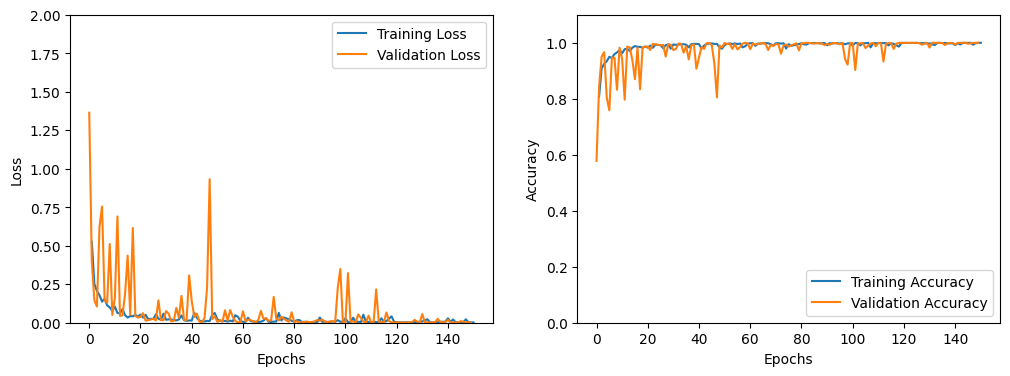

In [41]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [42]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 83) - Validation Loss: 0.001, Validation Accuracy: 1.000


In [43]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 1.000
Test Time: 10.17 seconds ---> 0.17 minutes


### Class Accuracy

In [44]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

Class 0 Accuracy: 1.000
Class 1 Accuracy: 1.000
Class 2 Accuracy: 0.999


### Confusion Matrix

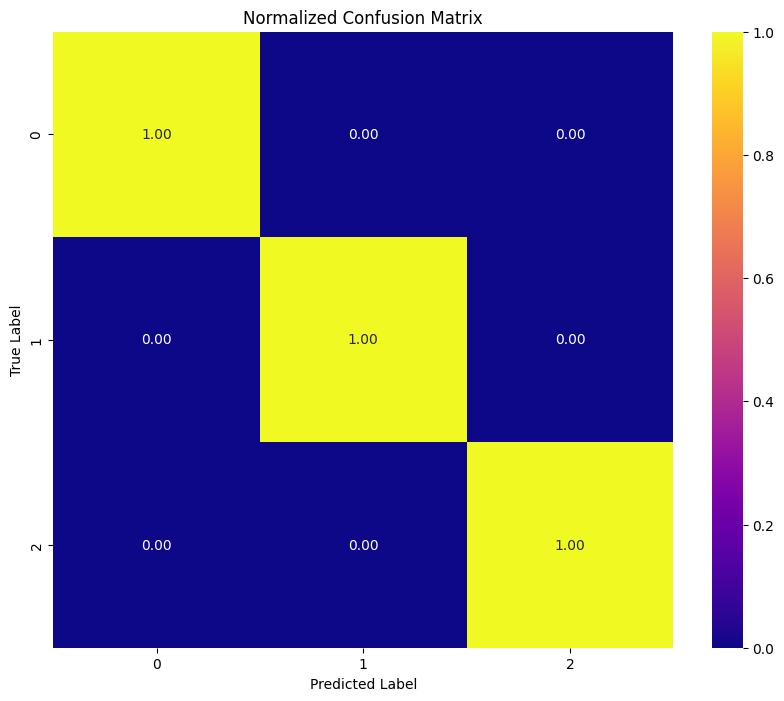

In [45]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

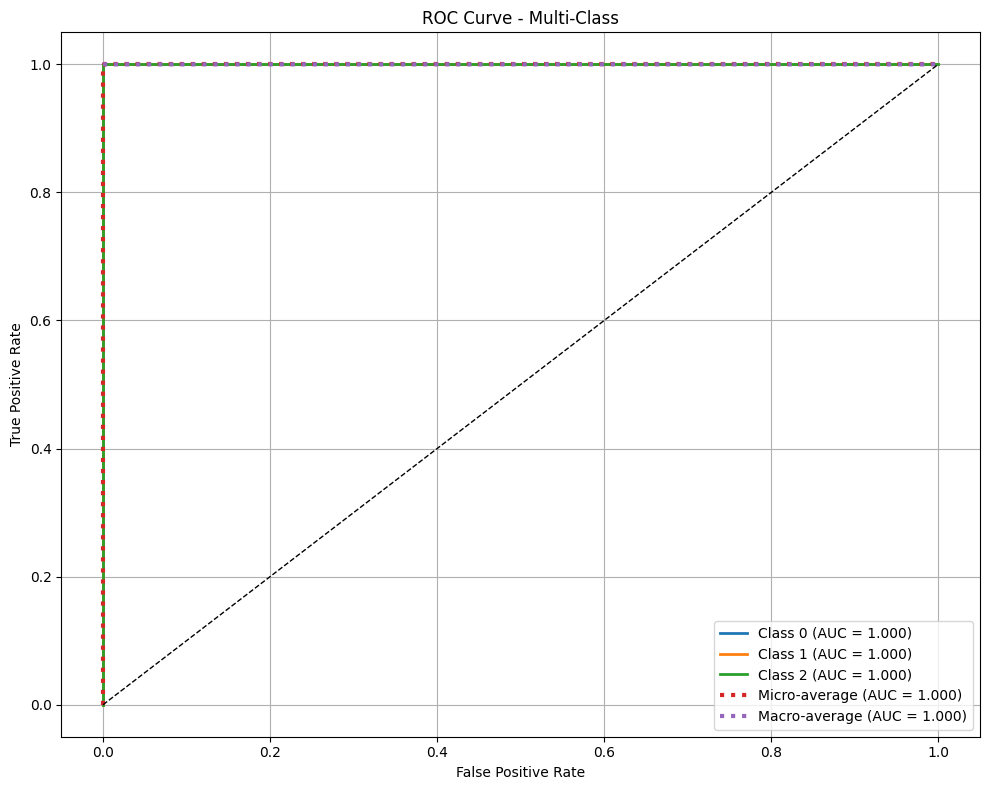

In [46]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()